In [5]:
from functions import *

import torch
import numpy as np
from torch import tensor, cat
import tqdm
import matplotlib.pyplot as plt

First attempt at fitting a Lagrangian's parameters. Start by creating training dataset:

100%|██████████| 4/4 [00:00<00:00, 214.49it/s]


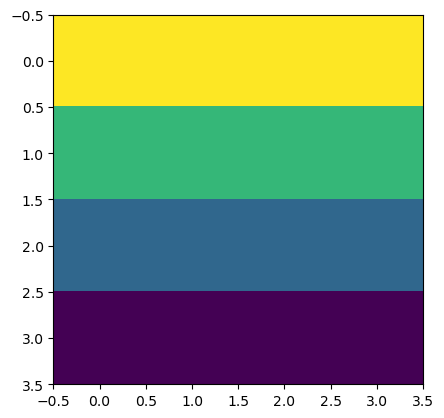

In [110]:
m = tensor([1.])
k = tensor([2.])

n_points = 4
q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1

def L(vec):
    # I know this is clunky, but I want to making the indexing simple for myself.
    #print(vec)
    m = vec[0]
    k = vec[1]
    q = vec[2]
    qdot = vec[3]

    L = 0.5*m*qdot**2 - 0.5*k*q**2
    return L

def qddot(Lag,m,k,q,qdot):
    """Returns d^2/dt^2 q given Lagrangian L"""
    v = torch.cat((m,k,q,qdot))
    #v = (m,k,q,qdot)
    full_hessian = autograd.functional.hessian(Lag,v)
    full_grad = autograd.functional.jacobian(Lag,v)
    """#debug printing functions for testing new Lagrangians
    if torch.isnan(full_hessian).max():
        print("NaN appeared in Hessian! Breaking loop!")
        return "break"
    if torch.isnan(full_grad).max():
        print("NaN appeared in Jacobian! Breaking loop!")
        return "break" """
    #print(full_grad)
    grad_q = full_grad[2]
    hess_q = full_hessian[2,2]
    hess_qdot = full_hessian[3,3]
    hess_q_qdot = full_hessian[2,3]
    qdd = (hess_qdot**(-1))*( grad_q - hess_q_qdot*qdot )
    return qdd
    


qgrid = torch.linspace(q_min,q_max,n_points)
qdotgrid = torch.linspace(qdot_min,qdot_max,n_points)


out = torch.zeros([3,n_points**2]) #out[0,:] = q_i, out[1,:] = qdot_i, out[2,:] = qddot_i
outmat = torch.zeros([n_points, n_points]) #contains qddot at each point in matrix form
counter = -1
for i in tqdm.trange(n_points):
    for j in range(n_points):
        counter += 1
        q = tensor([qgrid[i]],requires_grad = True)
        qdot = tensor([qdotgrid[j]],requires_grad = True)
        val = qddot(L,m,k,q,qdot)
        out[:,counter] = tensor([q, qdot, val])
        outmat[i,j] = val

out.requires_grad = True

plt.imshow(outmat.detach().numpy())



Visualize the loss surface around the true $(m,k)$ point

100%|██████████| 120/120 [01:36<00:00,  1.24it/s]

The original parameters are m = 1.0, k = 2.0


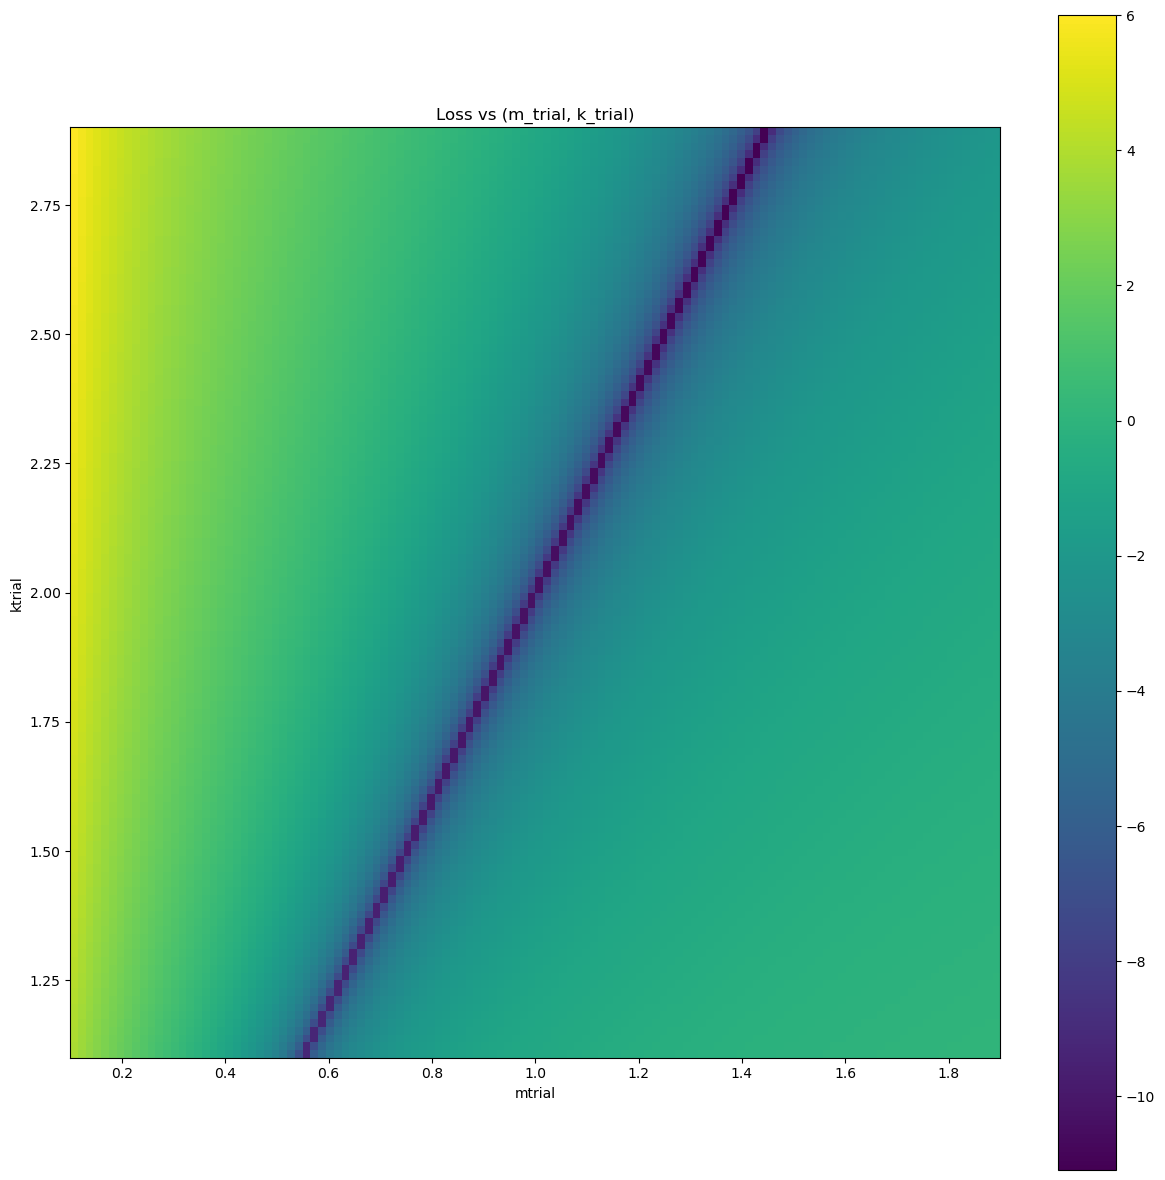

In [191]:
n_param_points = 120
box_width = .9

m_min = m[0] - box_width
m_max = m[0] + box_width
k_min = k[0] - box_width
k_max = k[0] + box_width
"""
m_min = 0.6
m_max = 1.4
k_min = 1.6
k_max = 2.4
"""
mtrialgrid = torch.linspace(m_min,m_max,n_param_points)
ktrialgrid = torch.linspace(k_min,k_max,n_param_points)


def L_trial(vec):
    # I know this is clunky, but I want to making the indexing simple for myself.
    #print(vec)
    m = vec[0]
    k = vec[1]
    q = vec[2]
    qdot = vec[3]

    L = 0.5*m*qdot**2 - 0.5*k*q**2
    return L


loss_mat = torch.zeros([n_param_points, n_param_points])


sz = out.size(1)
qdd_trials = torch.zeros(sz)

for i in tqdm.trange(n_param_points): #iterate over m
    mtrial = tensor([mtrialgrid[i]], requires_grad = True) #pick m_trial value from grid
    for j in range(n_param_points): #iterate over k
        ktrial = tensor([ktrialgrid[j]], requires_grad = True) #pick k_trial value from grid
        for l in range(sz): #iterate over dataset points
            q = tensor([out[0,l]], requires_grad = True)
            qdot = tensor([out[1,l]], requires_grad = True)
            qdd_trial = qddot(L_trial,mtrial,ktrial,q,qdot) #calculate qdd
            qdd_trials[l] = qdd_trial #store qdd
        loss_mat[i,j] = torch.sum( (qdd_trials - out[2,:])**2 )/sz #calculate loss function

"""#optional -- calculates optimal (m,k) for the trial points
mindex = np.where(loss_mat == loss_mat.min())[0][0]
kindex = np.where(loss_mat == loss_mat.min())[1][0]
m_opt = mtrialgrid[mindex].detach().numpy()
k_opt = ktrialgrid[mindex].detach().numpy()

m_out = m.detach().numpy()[0]
k_out = k.detach().numpy()[0]

print(f"Optimal m_trial = {m_opt:.3f}, true m = {m_out:.1f}")
print(f"Optimal k_trial = {k_opt:.3f}, true k = {k_out:.1f}")

print(f"Optimal k_trial/m_trial = {k_opt/m_opt}, true k/m = {k_out/m_out:.3f}")
"""

print(f"The original parameters are m = {m[0]}, k = {k[0]}")

#plotting
fig, axs = plt.subplots(1,1,figsize=(15,15))
test = axs.imshow(np.log(loss_mat.detach().numpy().T+1e-12), extent=[m_min,m_max,k_min,k_max],origin='lower')
axs.set_xlabel('mtrial')
axs.set_ylabel('ktrial')
fig.colorbar(test, ax=axs)
axs.set_title("Loss vs (m_trial, k_trial)")

plt.show()



Now use that training dataset to learn the Lagrangian's parameters:

100%|██████████| 100/100 [00:00<00:00, 109.17it/s]


The fit values are m = 1.175, k = 2.342, k/m = 1.993


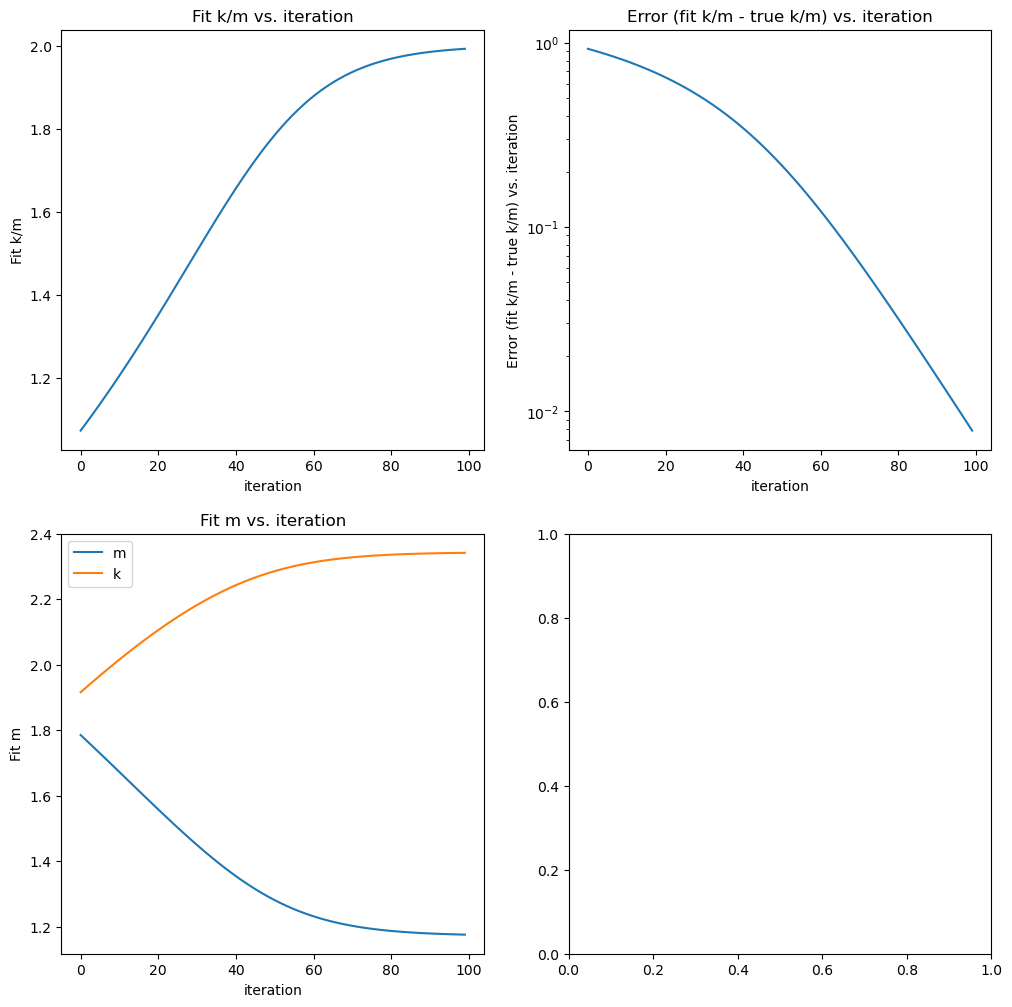

In [116]:
"""mtr = torch.rand(1, requires_grad = True) #initialize trial m
ktr = torch.rand(1, requires_grad = True) #initialize trial k

mtrial = 2*mtr
ktrial = 4*mtr"""

mtrial = m+2*box_width*(torch.rand(1, requires_grad = True)-0.5) #initialize trial m
ktrial = m+2*box_width*(torch.rand(1, requires_grad = True)-0.5) #initialize trial k

delta = 0.01
n_iterations = 100

#mtrial = 10*torch.rand(1) #initialize trial m
#ktrial = 10*torch.rand(1) #initialize trial k


def qddot_test(Lag,m,k,q,qdot):
    """Returns d^2/dt^2 q given Lagrangian L"""
    v = torch.cat((m,k,q,qdot))
    #v = (m,k,q,qdot)
    full_hessian = autograd.functional.hessian(Lag,v,create_graph=True)
    full_grad = autograd.functional.jacobian(Lag,v,create_graph=True)
    """#debug printing functions for testing new Lagrangians
    if torch.isnan(full_hessian).max():
        print("NaN appeared in Hessian! Breaking loop!")
        return "break"
    if torch.isnan(full_grad).max():
        print("NaN appeared in Jacobian! Breaking loop!")
        return "break" """
    #print(full_grad)
    grad_q = full_grad[2]
    hess_q = full_hessian[2,2]
    hess_qdot = full_hessian[3,3]
    hess_q_qdot = full_hessian[2,3]
    qdd = (hess_qdot**(-1))*( grad_q - hess_q_qdot*qdot )
    return qdd

def L_trial(vec):
    # I know this is clunky, but I want to making the indexing simple for myself.
    #print(vec)
    m = vec[0]
    k = vec[1]
    q = vec[2]
    qdot = vec[3]

    L = 0.5*m*qdot**2 - 0.5*k*q**2
    return L
    


sz = out.size(1)

m_hist = torch.zeros(n_iterations)
k_hist = torch.zeros(n_iterations)

dataset = out
#dataset.requires_grad = False
for l in tqdm.trange(n_iterations):
    for i in range(sz):
        q = tensor([dataset[0,i]], requires_grad = True)
        qdot = tensor([dataset[1,i]], requires_grad = True)
        qdd_trial = qddot_test(L_trial,mtrial,ktrial,q,qdot)
        loss = (qdd_trial - dataset[2,i])**2
    m_hist[l] = mtrial
    k_hist[l] = ktrial
    mg = autograd.grad(loss,mtrial,create_graph=True)
    kg = autograd.grad(loss,ktrial,create_graph=True)

    mtrial.data = tensor([mtrial.data[0] - delta*mg[0].data[0]])
    ktrial.data = tensor([ktrial.data[0] - delta*kg[0].data[0]])


#print(f"m = {mtrial.data[0]:.3f}, grad_m = {mg[0].detach().numpy()[0]:.3f}")
#print(f"k = {ktrial.data[0]:.3f}, grad_k = {kg[0].detach().numpy()[0]:.3f}")
#plt.plot(m_hist.detach().numpy(),label='m')
#plt.plot(k_hist.detach().numpy(),label='k')
#plt.legend()

m_final = mtrial.detach().numpy()[0]
k_final = ktrial.detach().numpy()[0]

print(f"The fit values are m = {m_final:.3f}, k = {k_final:.3f}, k/m = {k_final/m_final:.3f}")

fig, axs = plt.subplots(2,2,figsize=(12,12))
axs[0,0].plot(k_hist.detach().numpy()/m_hist.detach().numpy(),label='k/m')
axs[0,0].set_xlabel('iteration')
axs[0,0].set_ylabel('Fit k/m')
axs[0,0].set_title('Fit k/m vs. iteration')

axs[0,1].plot((np.abs(k_hist.detach().numpy()/m_hist.detach().numpy()-2)),label='k/m')
axs[0,1].set_xlabel('iteration')
axs[0,1].set_ylabel('Error (fit k/m - true k/m) vs. iteration')
axs[0,1].set_yscale('log')
axs[0,1].set_title('Error (fit k/m - true k/m) vs. iteration')

axs[1,0].plot(m_hist.detach().numpy(),label='m')
axs[1,0].set_xlabel('iteration')
axs[1,0].set_ylabel('Fit m')
axs[1,0].set_title('Fit m vs. iteration')
axs[1,0].plot(k_hist.detach().numpy(),label='k')
axs[1,0].legend()

plt.show()

Now fit multiple times and plot each path:

100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


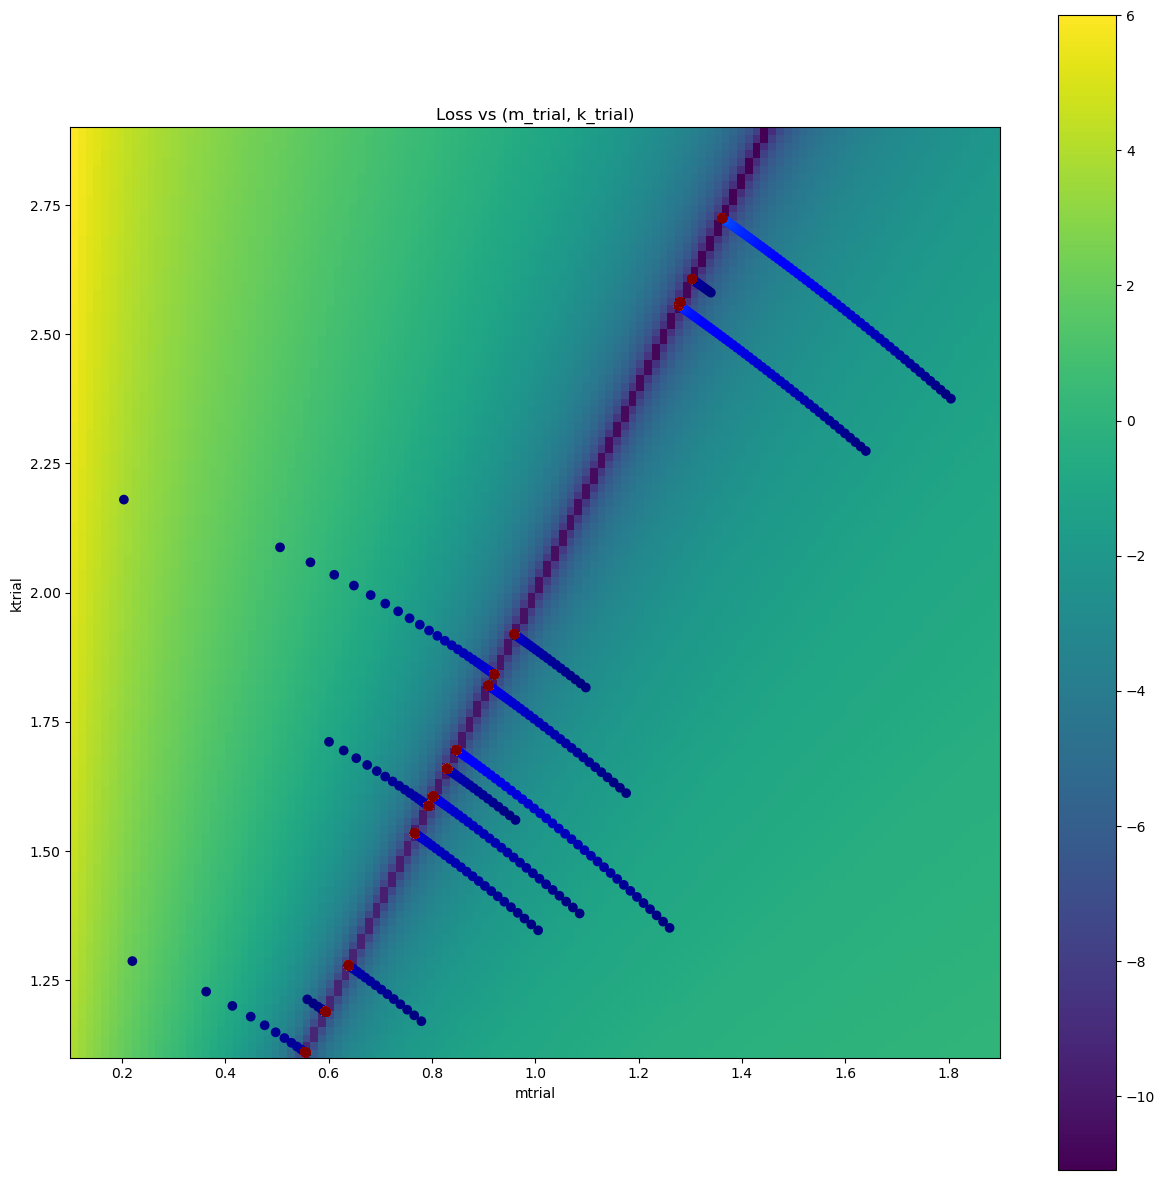

In [204]:
"""mtr = torch.rand(1, requires_grad = True) #initialize trial m
ktr = torch.rand(1, requires_grad = True) #initialize trial k

mtrial = 2*mtr
ktrial = 4*mtr"""



delta = 0.01
n_iterations = 300
n_paths = 15

#mtrial = 10*torch.rand(1) #initialize trial m
#ktrial = 10*torch.rand(1) #initialize trial k


def qddot_test(Lag,m,k,q,qdot):
    """Returns d^2/dt^2 q given Lagrangian L"""
    v = torch.cat((m,k,q,qdot))
    #v = (m,k,q,qdot)
    full_hessian = autograd.functional.hessian(Lag,v,create_graph=True)
    full_grad = autograd.functional.jacobian(Lag,v,create_graph=True)
    """#debug printing functions for testing new Lagrangians
    if torch.isnan(full_hessian).max():
        print("NaN appeared in Hessian! Breaking loop!")
        return "break"
    if torch.isnan(full_grad).max():
        print("NaN appeared in Jacobian! Breaking loop!")
        return "break" """
    #print(full_grad)
    grad_q = full_grad[2]
    hess_q = full_hessian[2,2]
    hess_qdot = full_hessian[3,3]
    hess_q_qdot = full_hessian[2,3]
    qdd = (hess_qdot**(-1))*( grad_q - hess_q_qdot*qdot )
    return qdd

def L_trial(vec):
    # I know this is clunky, but I want to making the indexing simple for myself.
    #print(vec)
    m = vec[0]
    k = vec[1]
    q = vec[2]
    qdot = vec[3]

    L = 0.5*m*qdot**2 - 0.5*k*q**2
    return L
    


sz = out.size(1)

m_hist = torch.zeros(n_iterations)
k_hist = torch.zeros(n_iterations)

dataset = out


fig, axs = plt.subplots(1,1,figsize=(15,15))
test = axs.imshow(np.log(loss_mat.detach().numpy().T+1e-12), extent=[m_min,m_max,k_min,k_max],origin='lower')
axs.set_xlabel('mtrial')
axs.set_ylabel('ktrial')
fig.colorbar(test, ax=axs)
axs.set_title("Loss vs (m_trial, k_trial)")

for i in tqdm.trange(n_paths):
    mtrial = m+2*box_width*(torch.rand(1, requires_grad = True)-0.5) #initialize trial m
    ktrial = k+2*box_width*(torch.rand(1, requires_grad = True)-0.5) #initialize trial k
    count = 0
    for l in range(n_iterations):
        count += 1
        for i in range(sz):
            q = tensor([dataset[0,i]], requires_grad = True)
            qdot = tensor([dataset[1,i]], requires_grad = True)
            qdd_trial = qddot_test(L_trial,mtrial,ktrial,q,qdot)
            loss = (qdd_trial - dataset[2,i])**2
        m_hist[l] = mtrial
        k_hist[l] = ktrial
        mg = autograd.grad(loss,mtrial,create_graph=True)
        kg = autograd.grad(loss,ktrial,create_graph=True)

        mg = mg[0].data[0]
        kg = kg[0].data[0]

        #mtrial.data = tensor([mtrial.data[0] - delta*mg])
        #ktrial.data = tensor([ktrial.data[0] - delta*kg])
        mupdate = torch.sign(mg)*torch.sqrt(torch.abs(mg))
        kupdate = torch.sign(kg)*torch.sqrt(torch.abs(kg))
        
        mtrial.data = tensor([mtrial.data[0] - delta*mupdate])
        ktrial.data = tensor([ktrial.data[0] - delta*kupdate])
    axs.scatter(m_hist.detach().numpy(),k_hist.detach().numpy(),c=np.arange(0,count,1)/count,cmap='jet')
    
plt.show()